create a new env with python=3.10

run the following code 

```bash
conda install pytorch torchvision torchaudio -c pytorch-nightly
```

## checking if torch is working properly or not 

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Install SAM2 repo 

In [2]:
# # Clone the repository
# !git clone https://github.com/facebookresearch/segment-anything-2.git

# # Change directory
# %cd segment-anything-2

# # Install the package with development dependencies
# %pip install -e 


restart the kernel and proceed without running the above cells again 
you can run the torch_gpu_checker code

## Imports and Resizing Functions

In this cell we import our libraries and define a helper function for resizing images and masks to 1024x1024.

In [3]:




import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from training.dataset.vos_raw_dataset import VOSRawDataset, VOSFrame, VOSVideo


# !!!!!!check with pranay sir for which interpolation constant from cv2 to use!!!!!!
def resize_image_cv2(image_path, output_path, size=(1024, 1024), interpolation=cv2.INTER_AREA):  
    """Read an image, resize it to given size, and save it."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    resized = cv2.resize(image, size, interpolation=interpolation)
    cv2.imwrite(output_path, resized)
    return resized

def ensure_resized_images(input_folder, output_folder, size=(1024, 1024)):
    """Resize all PNG images from input_folder and place in output_folder."""
    os.makedirs(output_folder, exist_ok=True)
    filenames = [f for f in os.listdir(input_folder) if f.endswith('.png')]
    for f in filenames:
        in_path = os.path.join(input_folder, f)
        out_path = os.path.join(output_folder, f)
        resize_image_cv2(in_path, out_path, size=size)
    return filenames



## Display Resized Samples

Here we resize a subset of images and masks and then plot a few examples to verify that the resizing worked correctly.

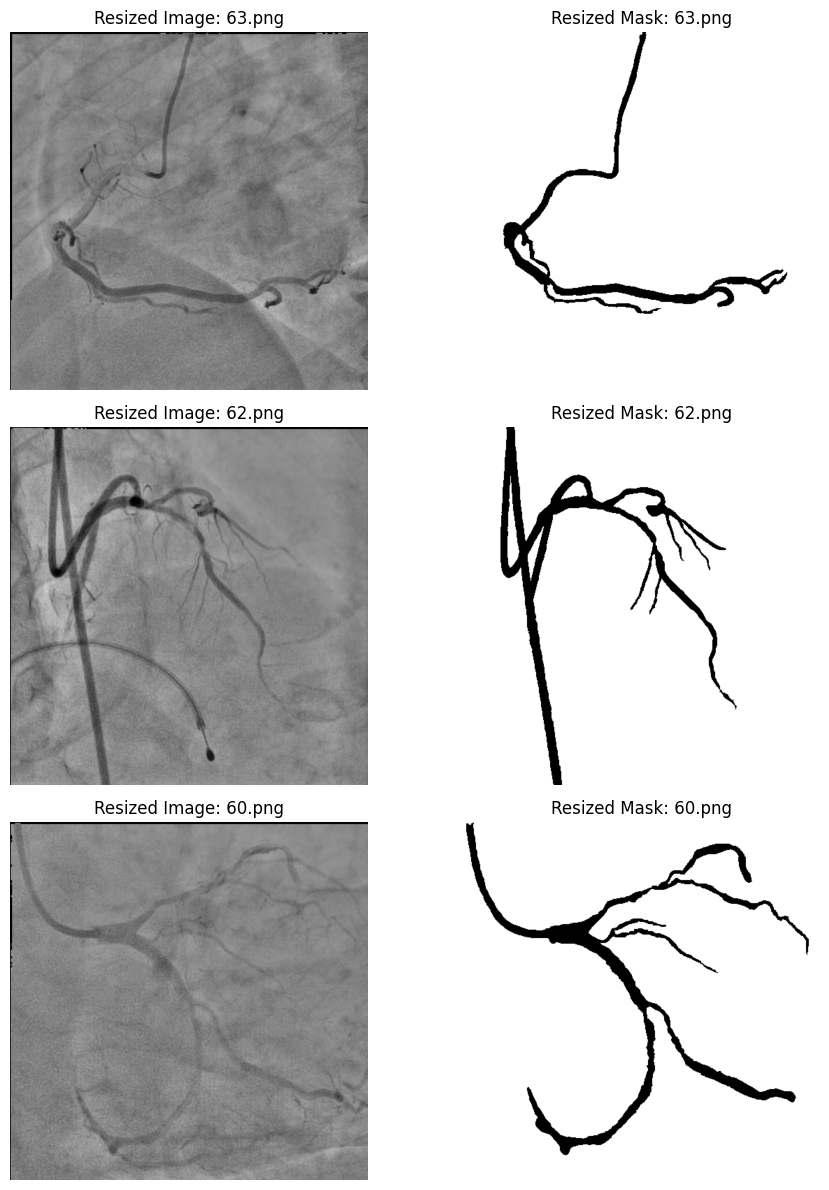

In [4]:


# Set paths for original images/masks and for resized outputs
orig_img_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Normalized_image"
orig_mask_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /mask"
resized_img_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Resized_image"
resized_mask_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Resized_mask"

# Resize and save images and masks
ensure_resized_images(orig_img_folder, resized_img_folder, size=(1024,1024))
ensure_resized_images(orig_mask_folder, resized_mask_folder, size=(1024,1024),)

# Plot a few examples
sample_files = os.listdir(resized_img_folder)[:3]

fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 4*len(sample_files)))
for i, f in enumerate(sample_files):
    img = cv2.cvtColor(cv2.imread(os.path.join(resized_img_folder, f)), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(resized_mask_folder, f), cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Resized Image: {f}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Resized Mask: {f}")
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()



## Augmenting Resized Images and Masks with Albumentations

In this cell, we'll augment our resized dataset (64 image/mask pairs) to roughly 320 pairs by generating 4 augmentations for each original pair. 
We use the albumentations library, which ensures that the same transform is applied consistently to both the image and its mask.
%% Code

/Users/anand/miniconda3/envs/sam2/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmentation complete, augmented images saved in: /Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_image
Augmented masks saved in: /Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_mask


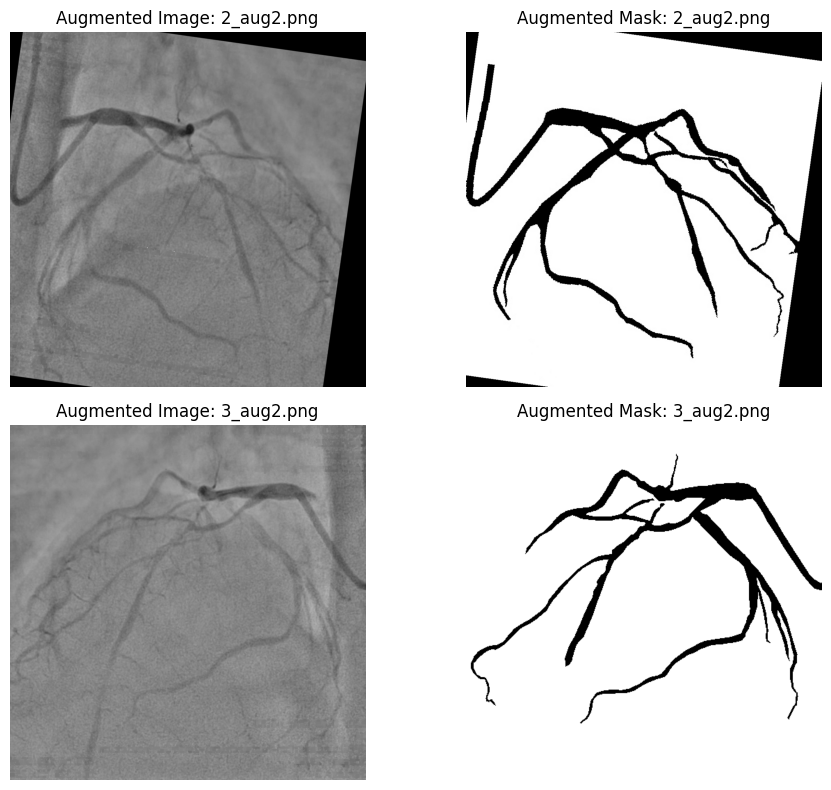

In [5]:


import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Define the augmentation pipeline.
# Feel free to adjust parameters for your specific use-case.
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.07, scale_limit=0.1, rotate_limit=15, p=0.7),
    # Adding brightness/contrast variation can sometimes help:
    A.RandomBrightnessContrast(p=0.5)
],
    additional_targets={'mask': 'mask'}
)

def augment_and_save(image_path, mask_path, aug_folder_img, aug_folder_mask, num_aug=4):
    """
    For a given image and mask file path, create 'num_aug' augmented versions,
    and save them to the provided augmented folder locations.
    The original image/mask pair is also copied to the augmented folder.
    """
    # Read original image and mask
    image = cv2.imread(image_path)  # image read in BGR
    mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # grayscale mask

    # Ensure destination folders exist
    os.makedirs(aug_folder_img, exist_ok=True)
    os.makedirs(aug_folder_mask, exist_ok=True)
    
    # Get base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Save original first
    orig_img_save = os.path.join(aug_folder_img, f"{base_name}.png")
    orig_mask_save = os.path.join(aug_folder_mask, f"{base_name}.png")
    cv2.imwrite(orig_img_save, image)
    cv2.imwrite(orig_mask_save, mask)
    
    # Generate augmentations
    for i in range(num_aug):
        augmented = augmentations(image=image, mask=mask)
        aug_image = augmented['image']
        aug_mask  = augmented['mask']
        
        # Build new file name
        aug_img_name = os.path.join(aug_folder_img, f"{base_name}_aug{i+1}.png")
        aug_mask_name = os.path.join(aug_folder_mask, f"{base_name}_aug{i+1}.png")
        
        # Save the augmented results
        cv2.imwrite(aug_img_name, aug_image)
        cv2.imwrite(aug_mask_name, aug_mask)

# Set folders (adjust these paths to match your environment)
resized_img_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Resized_image"
resized_mask_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Resized_mask"
augmented_img_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_image"
augmented_mask_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_mask"

# Get list of all resized image files (assuming PNG)
filenames = [f for f in os.listdir(resized_img_folder) if f.endswith('.png')]

# Process each image/mask pair
for f in filenames:
    img_path = os.path.join(resized_img_folder, f)
    mask_path = os.path.join(resized_mask_folder, f)
    augment_and_save(img_path, mask_path, augmented_img_folder, augmented_mask_folder, num_aug=4)
    
print(f"Augmentation complete, augmented images saved in: {augmented_img_folder}")
print(f"Augmented masks saved in: {augmented_mask_folder}")

# Optional: Display a couple of augmented samples (original + one augmentation)
sample_files = os.listdir(augmented_img_folder)[:2]  # pick two samples for demo
fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 4*len(sample_files)))
for i, file in enumerate(sample_files):
    # Display augmented image and mask side-by-side
    aug_img = cv2.cvtColor(cv2.imread(os.path.join(augmented_img_folder, file)), cv2.COLOR_BGR2RGB)
    
    # Derive corresponding mask file name (assuming same base naming scheme)
    base = file.split('_aug')[0]  # this works for both original and augmented images
    mask_file = base + ".png" if "aug" not in file else file
    aug_mask = cv2.imread(os.path.join(augmented_mask_folder, mask_file), cv2.IMREAD_GRAYSCALE)
    
    axes[i, 0].imshow(aug_img)
    axes[i, 0].set_title(f"Augmented Image: {file}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(aug_mask, cmap='gray')
    axes[i, 1].set_title(f"Augmented Mask: {mask_file}")
    axes[i, 1].axis('off')
    
plt.tight_layout()
plt.show()



## Dataset Class Definition with Train/Val/Test Splits

This cell defines a custom dataset class (inheriting from both
VOSRawDataset and torch.utils.data.Dataset) that uses filenames from the image directory.
We then create three splits (train/val/test) using scikit-learn's train_test_split.

In [6]:

 
# In this cell we define a custom dataset class that inherits from both
# VOSRawDataset (for compatibility with the SAM2 training code) and torch.utils.data.Dataset.
# We define __len__ and __getitem__ to enable use with a DataLoader.
# Splits (train, validation, test) are created using scikit-learn’s train_test_split.
# An optional transform can be applied to the image.
# Finally, __getitem__ loads the image from disk, converts it to RGB and a tensor,
# and also loads the corresponding mask as a tensor.

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# Custom segment loader that converts the binary mask to a torch tensor.
class CustomSegmentLoader:
    def __init__(self, mask_path):
        self.mask_path = mask_path

    def load_masks(self):
        # Read the mask in grayscale (it is assumed that arteries are black, background white)
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        # Ensure the mask is 1024x1024 (resize using NEAREST neighbor, to keep labels)
        mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
        # Convert to binary: pixel values < 128 become 1 (artery), otherwise 0 (background)
        mask = (mask < 128).astype(np.uint8)
        # Convert to a torch tensor with an added channel dimension
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        return {1: mask_tensor}

# Define the custom dataset.
class CoronaryArteriesDataset(VOSRawDataset, Dataset):
    def __init__(self, img_folder, gt_folder, split='train', transform=None):
        """
        Args:
            img_folder: Directory containing the (augmented) images.
            gt_folder: Directory containing the corresponding masks.
            split: 'train', 'val', or 'test'. The split is created using train_test_split.
            transform: Optional callable to apply to each image.
        """
        self.img_folder = img_folder
        self.gt_folder = gt_folder
        self.transform = transform

        # Get all filenames (without extension) for matching image/mask pairs.
        all_files = sorted([os.path.splitext(f)[0] for f in os.listdir(img_folder) if f.endswith('.png')])
        
        # Create splits: reserve 20% for test, then from the remaining, take 25% for validation (resulting in 70/15/15 or similar).
        train_val, test = train_test_split(all_files, test_size=0.2, random_state=42)
        train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.20 overall
        
        if split == 'train':
            self.image_names = train
        elif split == 'val':
            self.image_names = val
        elif split == 'test':
            self.image_names = test
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def get_video(self, idx):
        """
        Returns a video object (even though it contains just one frame)
        and a corresponding segment loader for the mask.
        """
        image_name = self.image_names[idx]
        image_path = os.path.join(self.img_folder, f"{image_name}.png")
        mask_path  = os.path.join(self.gt_folder, f"{image_name}.png")
        segment_loader = CustomSegmentLoader(mask_path)
        frames = [VOSFrame(0, image_path=image_path)]
        video = VOSVideo(video_name=image_name, video_id=idx, frames=frames)
        return video, segment_loader

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Use get_video to obtain the image path and segment loader.
        video, segment_loader = self.get_video(idx)
        # Load the image using OpenCV and convert from BGR to RGB.
        image = cv2.imread(video.frames[0].image_path)
        if image is None:
            raise ValueError(f"Could not load image at {video.frames[0].image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply transformation if provided.
        if self.transform:
            image = self.transform(image)
        else:
            # Convert to a float tensor and scale to [0,1]
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        # Load the mask.
        masks = segment_loader.load_masks()  # Returns a dict; we use key 1.
        mask = masks[1].float()  # Convert to float tensor.
        return image, mask

# Helper function to create the dataset splits.
def create_datasets(img_folder, gt_folder, transform=None):
    train_dataset = CoronaryArteriesDataset(img_folder, gt_folder, split='train', transform=transform)
    val_dataset = CoronaryArteriesDataset(img_folder, gt_folder, split='val', transform=transform)
    test_dataset = CoronaryArteriesDataset(img_folder, gt_folder, split='test', transform=transform)
    return train_dataset, val_dataset, test_dataset



## Testing the Dataset Splits

In this cell we create the train, val, and test splits and test the dataset by printing the sample sizes.
We also load one sample from the training dataset and display its details.


Total dataset size: 320
Train dataset size: 192
Validation dataset size: 64
Test dataset size: 64


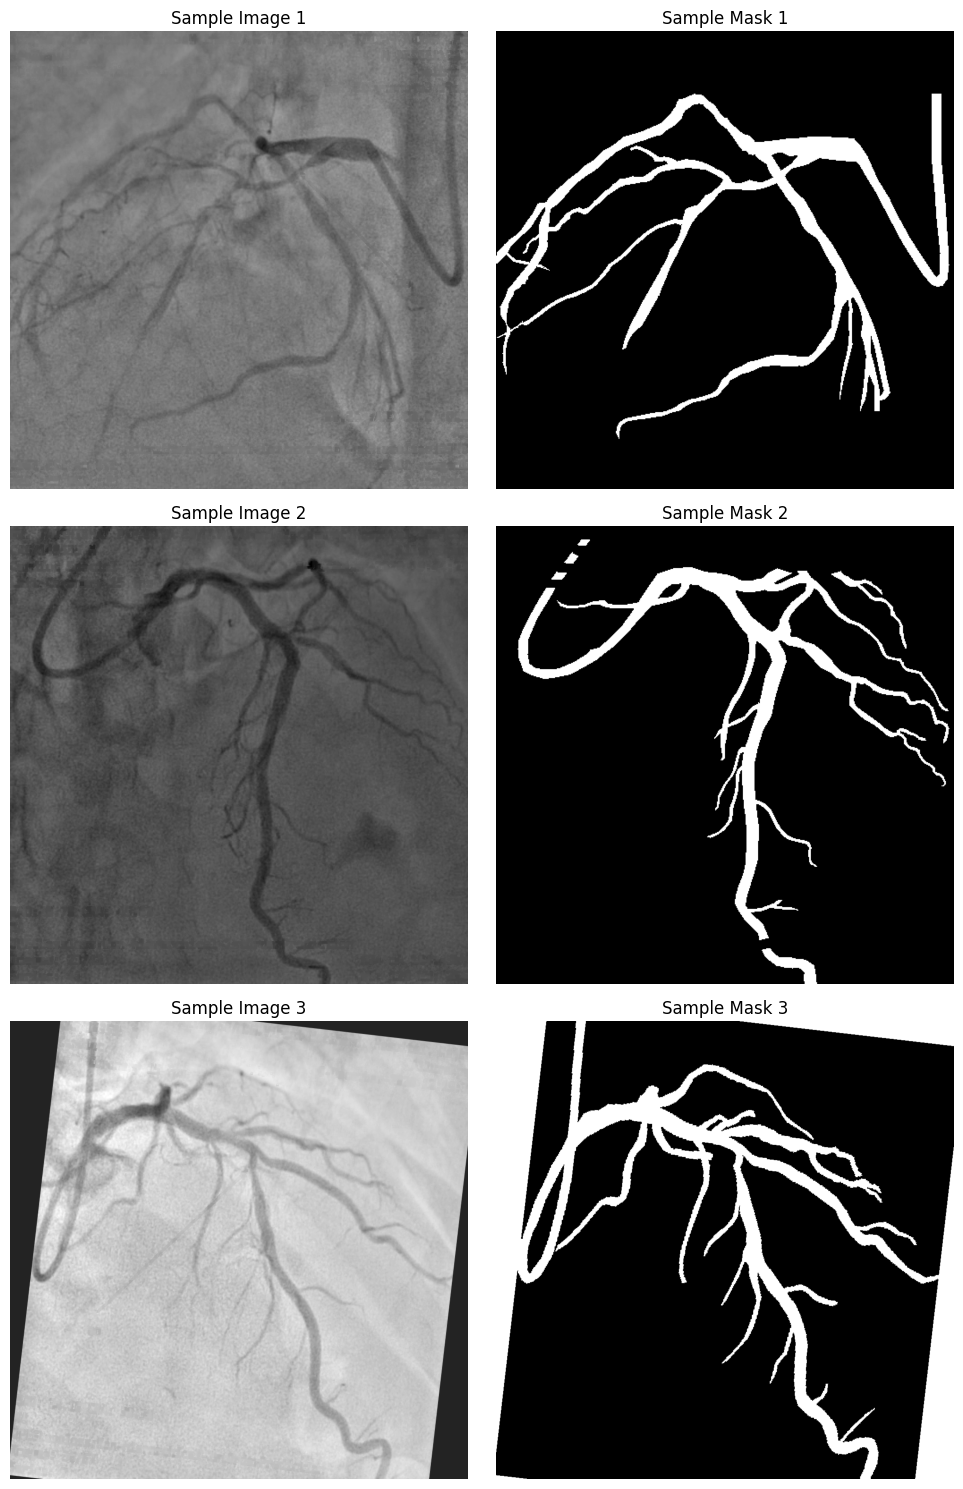

In [7]:

# In this cell we create the train, validation, and test datasets,
# print their sizes, and visualize a few sample image–mask pairs from the training set.


# Set directories for the augmented images and masks.
# (Update these paths as necessary.)
augmented_img_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_image"
augmented_mask_folder = "/Users/anand/STUDY/CASBLoDAM/SAM/64 Images from doctor /Augmented_mask"

# Create dataset splits.
train_dataset, val_dataset, test_dataset = create_datasets(augmented_img_folder, augmented_mask_folder)

print("Total dataset size:", len(train_dataset) + len(val_dataset) + len(test_dataset))
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

# Function to visualize a few samples.
import matplotlib.pyplot as plt

def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        # Convert the image tensor from (C, H, W) to (H, W, C) for plotting.
        image_np = image.permute(1, 2, 0).numpy()
        # For the mask, remove the channel dimension.
        mask_np = mask.squeeze(0).numpy()
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Sample Image {i+1}")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title(f"Sample Mask {i+1}")
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize three samples from the training dataset.
visualize_samples(train_dataset, num_samples=3)
